In [34]:
import numpy as np
import matplotlib 
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import fitsio
import glob

from sklearn.decomposition import SparsePCA

import sys
sys.path.append("../")
import pyrosl

from astropy.convolution import convolve, Gaussian2DKernel
from SPyFFI.Cosmics import cosmicImage

%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(16.0,9.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']


Populating the interactive namespace from numpy and matplotlib


CPU times: user 2.96 s, sys: 6.82 ms, total: 2.97 s
Wall time: 2.97 s


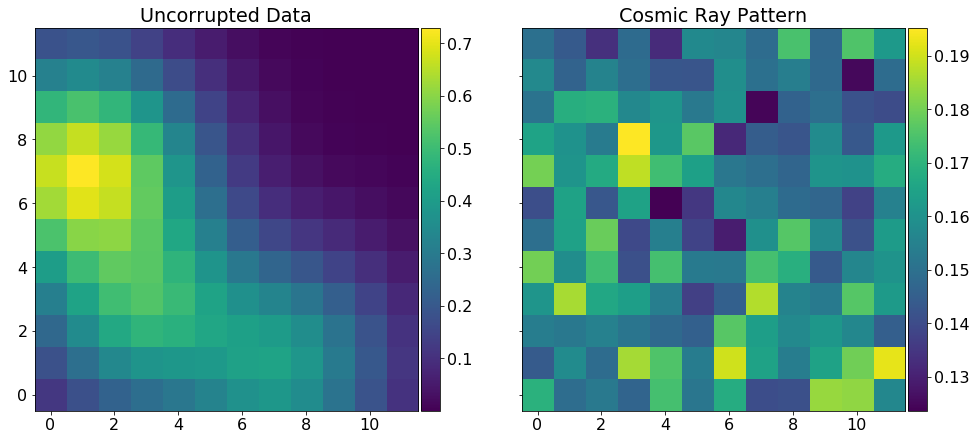

In [11]:
%%time

## use Christina's sample data

from scipy import signal
n_samples = 500
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal
nx, ny = 12, 12
dat = np.zeros((500, nx, ny))
dat[:,3,3]=s1
dat[:,7,1]=s2
dat[:,1,7]=s3
for idx, d in enumerate(dat):
    dat[idx] = convolve(d, Gaussian2DKernel(2.5))
# dat += 0.03* np.random.normal(size=dat.shape)
dat /= np.nanmax(dat)
# now add sparse noise in the form of simulated TESS cosmic rays

noise = np.zeros_like(dat)

for j in range(noise.shape[0]):
    cosmic = cosmicImage(size=int(2.**np.ceil(np.log2(max([nx,ny])))),exptime=120.0)
    if np.max(cosmic)>0.:
        cosmic /= np.nanmax(cosmic)
        noise[j,:,:] = cosmic[:nx,:ny]
    
sim = dat+noise

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
im1 = ax1.imshow(np.nanstd(dat,axis=0))
ax1.set_title('Uncorrupted Data')

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)

f.colorbar(im1,cax=cax)

im2 = ax2.imshow(np.nanstd(noise,axis=0))
ax2.set_title('Cosmic Ray Pattern')

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)

f.colorbar(im2,cax=cax2)


In [12]:
X = sim.reshape((n_samples,nx*ny)) # with noise
# X = dat.reshape((n_samples,nx*ny)) # no noise

# X /= X.max()


In [85]:
# Parameters for ROSL
regROSL = 2
estROSL = 10

# Parameters for ROSL+
regROSLp = 0.01
estROSLp = 10
samplesp = (250, 250)


In [86]:
# Run the full version
print ' '
full_rosl = pyrosl.ROSL(
    method = 'full',
    rank = estROSL,
    reg = regROSL,
    verbose = True
   )


In [87]:
%%time
loadings, components, E = full_rosl._fit(X)
loadings = loadings[:, :full_rosl.rank_]
model = np.dot(loadings, full_rosl.components_)
sparse = E.reshape(np.shape(dat))
lowrank = model.reshape(np.shape(dat))

print 'Rank found',full_rosl.rank_


Array must be in Fortran-order. Converting now.
Rank found 10
CPU times: user 87.2 ms, sys: 18.5 ms, total: 106 ms
Wall time: 90.8 ms


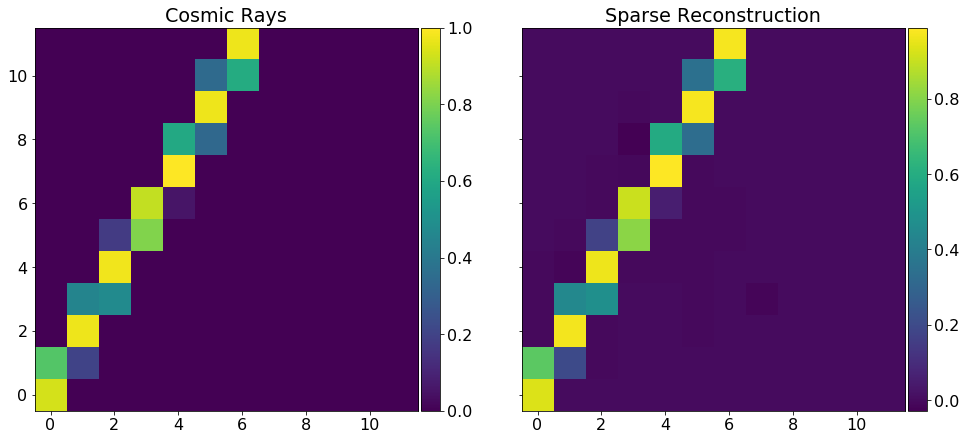

In [88]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
index = 3
im1 = ax1.imshow(noise[index,:,:])
ax1.set_title('Cosmic Rays')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)

f.colorbar(im1,cax=cax)

im2 = ax2.imshow(sparse[index,:,:])
ax2.set_title('Sparse Reconstruction')
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)

f.colorbar(im2,cax=cax2)


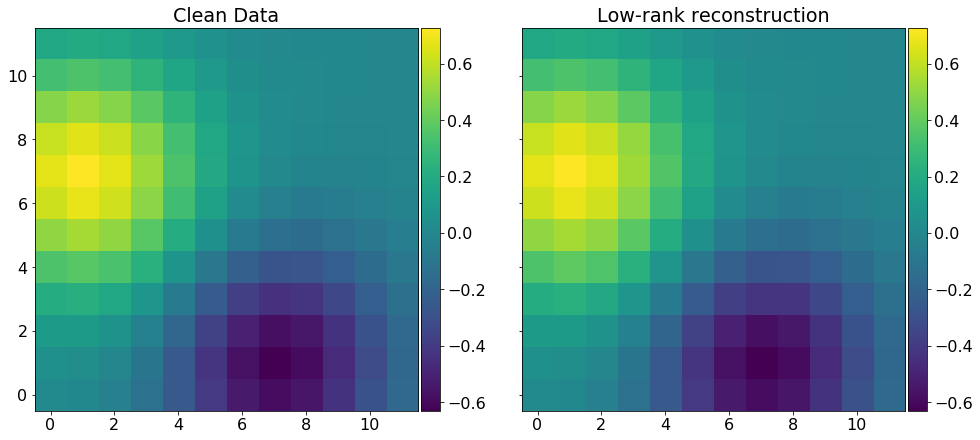

In [89]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
index = 3
im1 = ax1.imshow(dat[index,:,:])
ax1.set_title('Clean Data')

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)

f.colorbar(im1,cax=cax)

im2 = ax2.imshow(lowrank[index,:,:])
ax2.set_title('Low-rank reconstruction')

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)

f.colorbar(im2,cax=cax2)


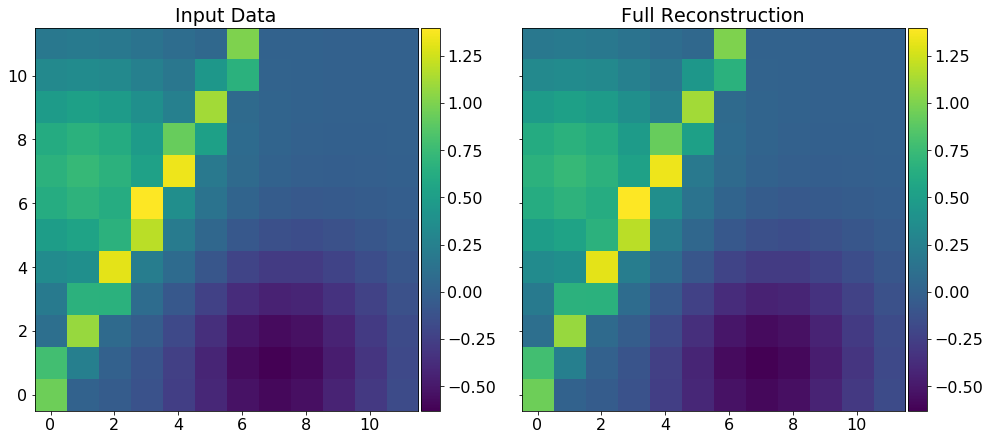

In [90]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
index = 3

im1 = ax1.imshow(sim[index,:,:])
ax1.set_title('Input Data')

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)

f.colorbar(im1,cax=cax)

im2 = ax2.imshow((sparse+lowrank)[index,:,:])
ax2.set_title('Full Reconstruction')
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)

f.colorbar(im2,cax=cax2)


In [91]:
def all_plots(index,f):

    im1 = ax1.imshow(sim[index,:,:])
    ax1.set_title('Input Data')

#     divider = make_axes_locatable(ax1)
#     cax = divider.append_axes("right", size="5%", pad=0.05)

#     f.colorbar(im1,cax=cax)

    im2 = ax2.imshow((sparse)[index,:,:])
    ax2.set_title('Sparse')
#     divider2 = make_axes_locatable(ax2)
#     cax2 = divider2.append_axes("right", size="5%", pad=0.05)

#     f.colorbar(im2,cax=cax2)

    im3 = ax3.imshow((lowrank)[index,:,:])
    ax3.set_title('Low Rank')
#     divider3 = make_axes_locatable(ax3)
#     cax3 = divider3.append_axes("right", size="5%", pad=0.05)

#     f.colorbar(im3,cax=cax3)

    im4 = ax4.imshow((dat)[index,:,:])
    ax4.set_title('Ideal')


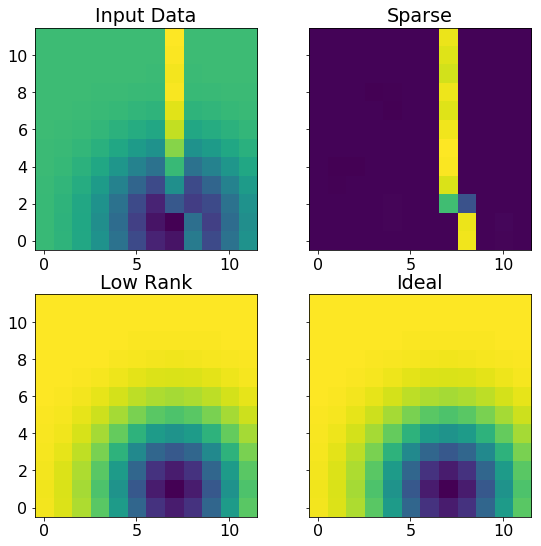

In [92]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True,figsize=(9.0,9.0))

all_plots(0,f)

In [93]:
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)


0
10
20
30
40
50
60
70
80
90
Saved to test_video.mp4
CPU times: user 2min 17s, sys: 11.9 s, total: 2min 29s
Wall time: 1min 26s


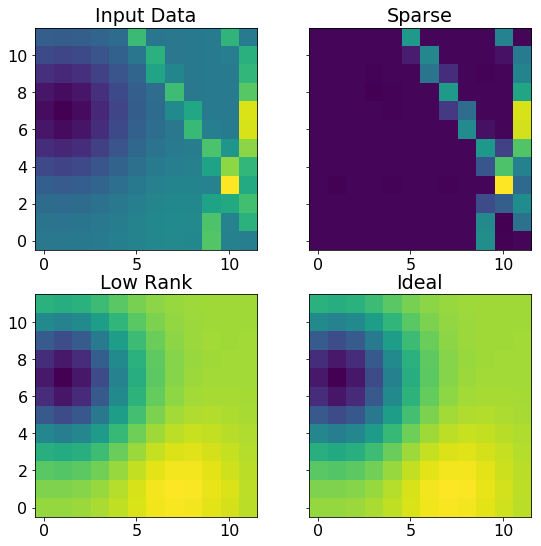

In [94]:
%%time 
plt.rcParams["animation.html"] = "jshtml"
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True,figsize=(9.0,9.0))

with writer.saving(f, "test_video.mp4", 100):

    for i in range(100):
        if i % 10 == 0:
            print i 
        all_plots(i,f)
        writer.grab_frame()
print 'Saved to test_video.mp4'